# Percentile Forecast Optimization

This notebook focuses on percentile-based forecasts.
It optimizes percentile targets first without aggregation, then with an aggregation window.


## Setup


In [1]:
import pandas as pd

from replenishment import (
    PercentileForecastOptimizationPolicy,
    build_percentile_forecast_candidates_from_standard_rows,
    build_replenishment_decisions_from_simulations,
    evaluate_aggregation_and_forecast_target_costs,
    evaluate_forecast_target_costs,
    generate_standard_simulation_rows,
    optimize_aggregation_and_forecast_targets,
    optimize_forecast_targets,
    plot_replenishment_decisions,
    replenishment_decision_rows_to_dataframe,
    split_standard_simulation_rows,
    simulate_replenishment_with_aggregation,
    standard_simulation_rows_from_dataframe,
    standard_simulation_rows_to_dataframe,
)


## Generate Sample Data


In [2]:
rows = generate_standard_simulation_rows(
    n_unique_ids=3,
    periods=120,
    history_mean=18,
    history_std=1,
    forecast_mean=17,
    forecast_std=2,
    initial_on_hand=1,
    current_stock=1,
   # seed=7,
    holding_cost_per_unit=1,
    stockout_cost_per_unit=1.5,
    order_cost_per_order=1,
    percentile_multipliers={
        "p10": 0.8,
        "p25": 0.9,
        "p50": 1.0,
        "p55": 1.05,
        "p6": 1.1,
        "p75": 1.2,
        "p90": 1.3,
    },
)
df = standard_simulation_rows_to_dataframe(rows, library="pandas")

df = df.drop(columns=["is_forecast"])
cutoff_period = 110
cutoff = sorted(df["ds"].unique())[cutoff_period - 1]
rows = standard_simulation_rows_from_dataframe(df, cutoff=cutoff)


In [3]:
df.columns


Index(['unique_id', 'ds', 'forecast', 'actuals', 'holding_cost_per_unit',
       'stockout_cost_per_unit', 'order_cost_per_order', 'lead_time',
       'initial_on_hand', 'current_stock', 'forecast_p10', 'forecast_p25',
       'forecast_p50', 'forecast_p55', 'forecast_p6', 'forecast_p75',
       'forecast_p90'],
      dtype='str')

## Split Backtest vs Forecast


In [4]:
backtest_rows, forecast_rows = split_standard_simulation_rows(rows)


## Step 1: Optimize Percentile Target (No Aggregation)


In [5]:
percentile_configs = build_percentile_forecast_candidates_from_standard_rows(
    backtest_rows,
    include_mean=True,
)
percentile_costs = evaluate_forecast_target_costs(percentile_configs)
percentile_cost_rows = [
    {"unique_id": uid, "target": target, "total_cost": cost}
    for uid, targets in percentile_costs.items()
    for target, cost in targets.items()
]
percentile_cost_df = pd.DataFrame(percentile_cost_rows)
percentile_cost_df


,unique_id,target,total_cost
0,A,p10,3084.5
1,A,p25,3084.5
2,A,p50,3084.5
3,A,p55,3084.5
4,A,p6,2299.5
5,A,p75,11385.5
6,A,p90,21317.5
7,A,mean,3084.5
8,B,p10,3081.5
9,B,p25,3081.5


In [6]:
percentile_result = optimize_forecast_targets(percentile_configs)

forecast_percentile_configs = build_percentile_forecast_candidates_from_standard_rows(
    forecast_rows,
    include_mean=True,
)
forecast_percentile_simulations = {}
for unique_id, config in forecast_percentile_configs.items():
    target = percentile_result[unique_id].target
    policy = PercentileForecastOptimizationPolicy(
        forecast=config.forecast_candidates[target],
        lead_time=config.lead_time,
    )
    forecast_percentile_simulations[unique_id] = simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=policy,
        aggregation_window=1,
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )

percentile_decision_rows = build_replenishment_decisions_from_simulations(
    forecast_rows,
    forecast_percentile_simulations,
    percentile_target={
        uid: percentile_result[uid].target
        for uid in forecast_percentile_simulations
    },
)
percentile_decision_df = replenishment_decision_rows_to_dataframe(
    percentile_decision_rows,
    library="pandas",
)
percentile_decision_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,incoming_stock,starting_stock,ending_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2033-01-13,19,18,20,0,1,0,1,0,0,19,17,17,None,1,p6
1,A,2033-02-12,18,18,19,19,19,1,2,0,1,18,16,0,None,1,p6
2,A,2033-03-14,19,18,18,18,19,1,2,0,1,19,16,0,None,1,p6
3,A,2033-04-13,20,18,19,19,20,2,3,0,2,20,15,0,None,1,p6
4,A,2033-05-13,18,19,20,20,22,3,5,0,3,18,14,0,None,1,p6


### Plot (No Aggregation)


0    17
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
Name: missed_sales, dtype: int64


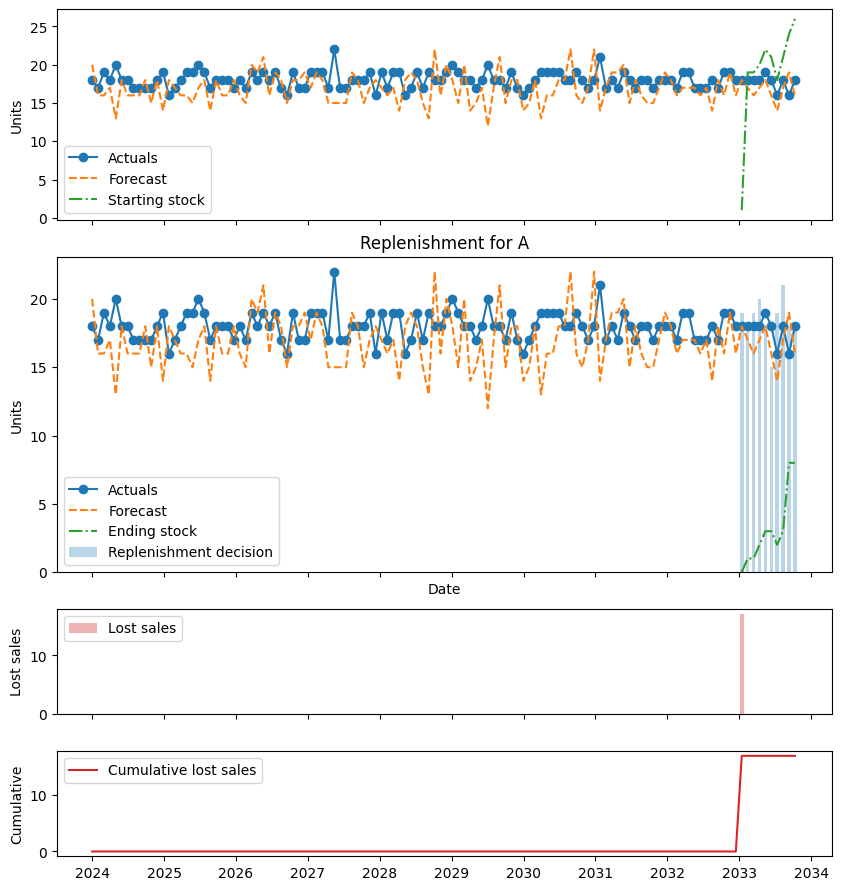

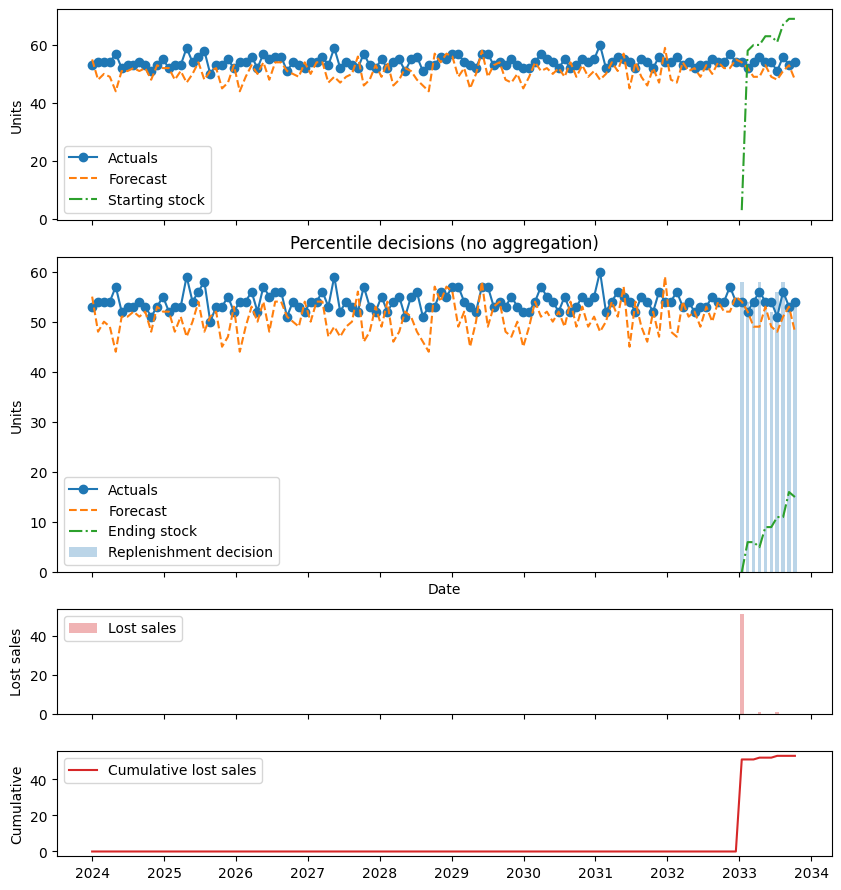

In [7]:
example_id = df["unique_id"].iloc[0]
plot_replenishment_decisions(df, percentile_decision_df, unique_id=example_id)
plot_replenishment_decisions(
    df,
    percentile_decision_df,
    aggregate=True,
    title="Percentile decisions (no aggregation)",
)


## Step 2: Optimize Aggregation Window + Percentile Target


In [8]:
agg_percentile_costs = evaluate_aggregation_and_forecast_target_costs(
    percentile_configs,
    candidate_windows=[1],
)
agg_percentile_cost_rows = [
    {
        "unique_id": uid,
        "window": window,
        "target": target,
        "total_cost": cost,
    }
    for uid, window_costs in agg_percentile_costs.items()
    for window, targets in window_costs.items()
    for target, cost in targets.items()
]
agg_percentile_cost_df = pd.DataFrame(agg_percentile_cost_rows)
agg_percentile_cost_df.head()


,unique_id,window,target,total_cost
0,A,1,p10,3084.5
1,A,1,p25,3084.5
2,A,1,p50,3084.5
3,A,1,p55,3084.5
4,A,1,p6,2299.5


In [9]:
agg_percentile_results = optimize_aggregation_and_forecast_targets(
    percentile_configs,
    candidate_windows=[1, 2, 3, 4, 5, 6],
)

forecast_percentile_configs = build_percentile_forecast_candidates_from_standard_rows(
    forecast_rows,
    include_mean=True,
)
forecast_percentile_simulations = {}
for unique_id, config in forecast_percentile_configs.items():
    choice = agg_percentile_results[unique_id]
    policy = PercentileForecastOptimizationPolicy(
        forecast=config.forecast_candidates[choice.target],
        lead_time=config.lead_time,
    )
    forecast_percentile_simulations[unique_id] = simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=policy,
        aggregation_window=choice.window,
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )

agg_percentile_decision_rows = build_replenishment_decisions_from_simulations(
    forecast_rows,
    forecast_percentile_simulations,
    aggregation_window={
        uid: agg_percentile_results[uid].window
        for uid in forecast_percentile_simulations
    },
    percentile_target={
        uid: agg_percentile_results[uid].target
        for uid in forecast_percentile_simulations
    },
)
agg_percentile_decision_df = replenishment_decision_rows_to_dataframe(
    agg_percentile_decision_rows,
    library="pandas",
)
agg_percentile_decision_df.head(10)


,unique_id,ds,quantity,demand,forecast_quantity,incoming_stock,starting_stock,ending_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2033-01-13,37,36,39,0,1,0,1,0,0,37,35,35,None,2,p6
1,A,2033-03-14,38,36,37,37,37,1,2,0,1,38,34,0,None,2,p6
2,A,2033-05-13,34,37,38,38,39,2,4,0,2,34,33,0,None,2,p6
3,A,2033-07-12,39,34,34,34,36,2,1,0,2,39,33,0,None,2,p6
4,A,2033-09-10,39,34,39,39,41,7,6,0,7,39,28,0,None,2,p6
5,B,2033-01-13,51,53,56,0,1,0,1,0,0,51,52,52,None,3,p6
6,B,2033-04-13,59,53,51,51,51,0,0,0,0,59,54,2,None,3,p6
7,B,2033-07-12,16,52,59,59,59,7,5,0,7,16,47,0,None,3,p6
8,B,2033-10-10,16,18,16,16,23,5,0,0,5,16,49,0,None,3,p6
9,C,2033-01-13,36,35,39,0,1,0,1,0,0,36,34,34,None,2,p6


In [10]:
agg_percentile_decision_df.columns
agg_percentile_decision_df["missed_sales"].sum()


np.int64(125)

### Plot (Optimized Aggregation)


In [11]:
agg_percentile_decision_df['missed_sales'].sum()

np.int64(125)

In [12]:
agg_percentile_decision_df

,unique_id,ds,quantity,demand,forecast_quantity,incoming_stock,starting_stock,ending_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2033-01-13,37,36,39,0,1,0,1,0,0,37,35,35,None,2,p6
1,A,2033-03-14,38,36,37,37,37,1,2,0,1,38,34,0,None,2,p6
2,A,2033-05-13,34,37,38,38,39,2,4,0,2,34,33,0,None,2,p6
3,A,2033-07-12,39,34,34,34,36,2,1,0,2,39,33,0,None,2,p6
4,A,2033-09-10,39,34,39,39,41,7,6,0,7,39,28,0,None,2,p6
5,B,2033-01-13,51,53,56,0,1,0,1,0,0,51,52,52,None,3,p6
6,B,2033-04-13,59,53,51,51,51,0,0,0,0,59,54,2,None,3,p6
7,B,2033-07-12,16,52,59,59,59,7,5,0,7,16,47,0,None,3,p6
8,B,2033-10-10,16,18,16,16,23,5,0,0,5,16,49,0,None,3,p6
9,C,2033-01-13,36,35,39,0,1,0,1,0,0,36,34,34,None,2,p6


In [14]:
agg_percentile_decision_df.columns


Index(['unique_id', 'ds', 'quantity', 'demand', 'forecast_quantity',
       'incoming_stock', 'starting_stock', 'ending_stock', 'starting_on_hand',
       'ending_on_hand', 'current_stock', 'on_order', 'backorders',
       'missed_sales', 'sigma', 'aggregation_window', 'percentile_target'],
      dtype='str')

0    35
1     0
2     0
3     0
4     0
Name: missed_sales, dtype: int64


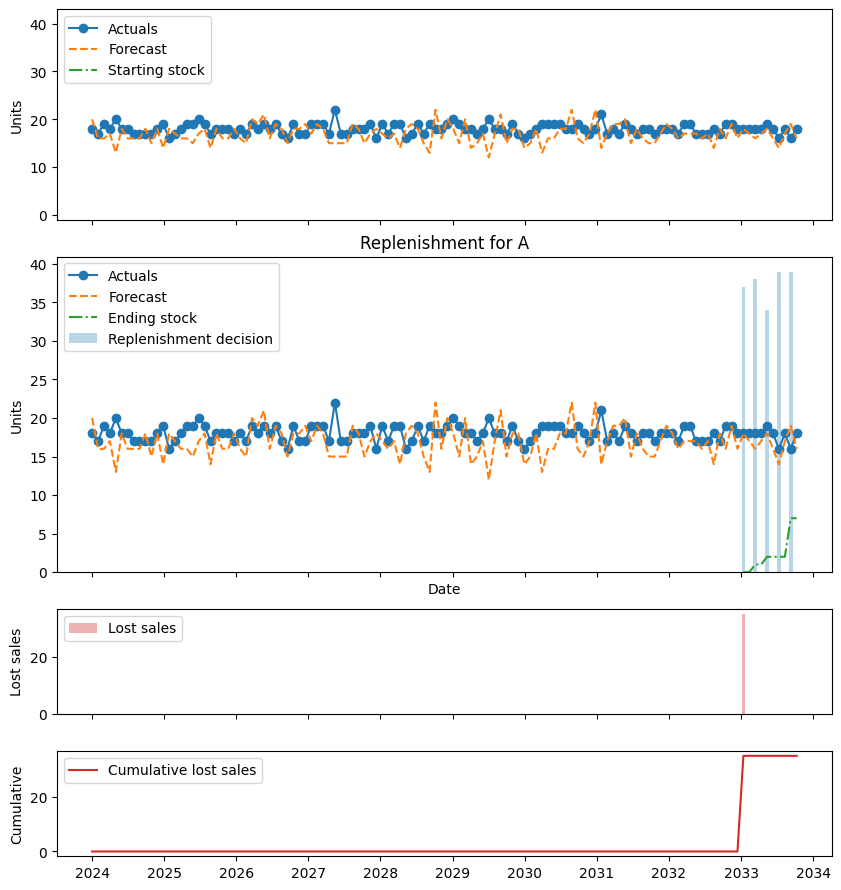

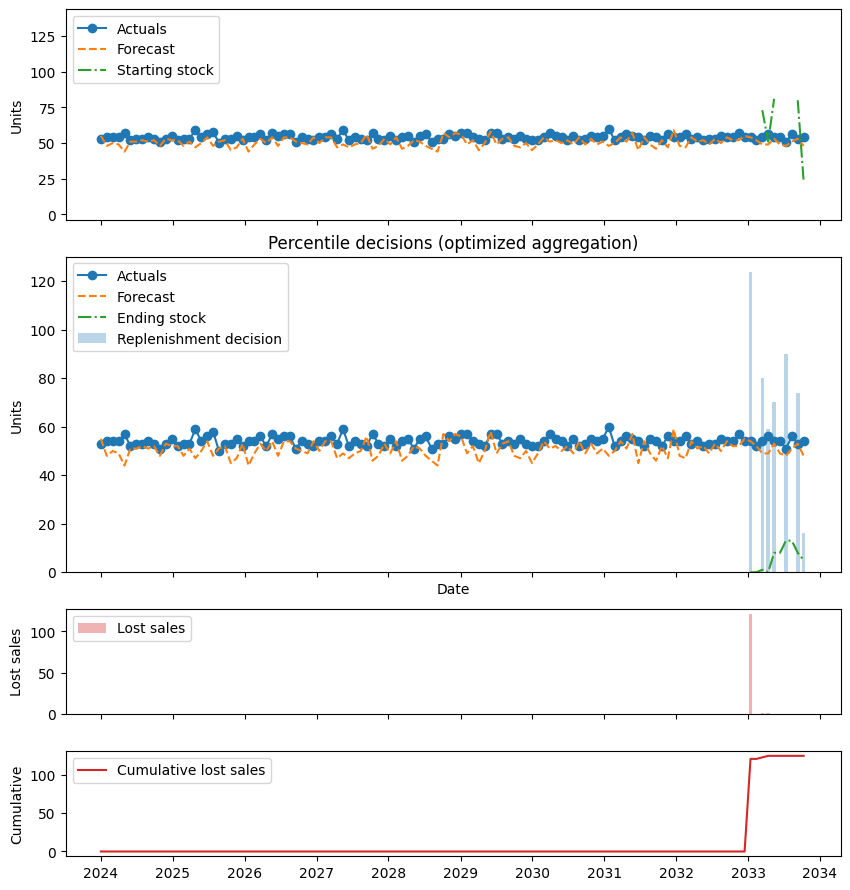

In [13]:
example_id = df["unique_id"].iloc[0]
plot_replenishment_decisions(df, agg_percentile_decision_df, unique_id=example_id)
plot_replenishment_decisions(
    df,
    agg_percentile_decision_df,
    aggregate=True,
    title="Percentile decisions (optimized aggregation)",
)
